# SageMaker POC: Credit Card Fraud

In [1]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from time import gmtime, strftime
import json

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

%matplotlib inline

## Download the data

In [6]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip -O data/creditcardfraud.zip
!unzip data/creditcardfraud -d data
!rm data/creditcardfraud.zip

--2019-11-01 15:29:08--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘data/creditcardfraud.zip’

data/creditcardfrau 100%[===================>]  65.95M  66.7MB/s    in 1.0s    

2019-11-01 15:29:09 (66.7 MB/s) - ‘data/creditcardfraud.zip’ saved [69155632/69155632]

Archive:  data/creditcardfraud.zip
  inflating: data/creditcard.csv     


In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [3]:
# S3 bucket name
bucket = 'model-bucket-test-1234567'
s3_client = boto3.client('s3')
s3_client.create_bucket(Bucket=bucket)

{'ResponseMetadata': {'RequestId': '86FC0361267050AD',
  'HostId': '4QFuM34HQLNyCLYiYdip/0ykrhPiPEuqHT9dAaQ+ae7ULEPfrCqB7vZ+WxHX0Opbr7tW34OVsUM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '4QFuM34HQLNyCLYiYdip/0ykrhPiPEuqHT9dAaQ+ae7ULEPfrCqB7vZ+WxHX0Opbr7tW34OVsUM=',
   'x-amz-request-id': '86FC0361267050AD',
   'date': 'Fri, 01 Nov 2019 16:29:16 GMT',
   'location': '/model-bucket-test-1234567',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/model-bucket-test-1234567'}

## Load helper functions

In [4]:

def train_test_split(transaction_df, train_frac= 0.7, seed=1):
    # convert the df into a matrix for ease of splitting
    df_matrix = transaction_df.as_matrix()
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)


def make_csv(x, y, filename, data_dir):
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).to_csv(os.path.join(data_dir, filename), header=False, index=False)
    print('Path created: '+str(data_dir)+'/'+str(filename))
    
    
def get_predictions(predictor, test_features):
    # get the predictions on the test data
    prediction_batches = [predictor.predict(batch) 
                          for batch in np.array_split(test_features.astype('float32'), 100)]

    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                     for batch in prediction_batches])
    return test_preds


def evaluate(test_preds, test_labels, verbose=True):
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


def filter_test_features(test_features, test_labels):
    # get all of the positives
    filtered_labels = []
    filtered_features = []
    for idx in range(len(test_labels)):
        if test_labels[idx] == 1:
            filtered_labels.append(test_labels[idx])
            filtered_features.append(test_features[idx])

    # convert positives into numpy arrays
    filtered_features = np.array(filtered_features)
    filtered_labels = np.array(filtered_labels)
            
    # get the fisrst thousand of the test featrues so we have some negastives
    negatives_features = test_features[:2000]
    negatives_labels = test_labels[:2000]
    
    # combine the postives and the negatives
    features = np.concatenate((negatives_features, filtered_features), axis=0)
    labels = np.concatenate((negatives_labels, filtered_labels), axis=0)
    
    return (features, labels)


def predict_with_client(filtered_features, endpoint_name, verbose=False):
    # get predcitions from the model using the client (this is slow dont send to many)
    prediction_results = []
    prediction_results_parsed = []
    for feature in (filtered_features):
        response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
                                                    EndpointName = endpoint_name,
                                                    ContentType = 'text/csv',
                                                    Body = ','.join(map(str, feature)))
        prediction_results.append(response['Body'].read().decode("utf-8"))
    # clean the preductions ands return only the output value
    for prediction in prediction_results:
        if verbose:
            print(prediction)
        prediction_results_parsed.append(
                json.loads(prediction)
            .get('predictions')[0]
            .get('predicted_label')
        )
    return np.array(prediction_results_parsed)

# Explore the Data

In [5]:
local_data = 'data/creditcard.csv'

# print out some data
creditcard_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', creditcard_df.shape)
creditcard_df.head()

Data shape (rows, cols):  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Class imbalance

In [6]:
# look for the class imbalance
print(f'total number of positives: {len(creditcard_df[creditcard_df.Class == 1])}')
print(f'total number of negatives: {len(creditcard_df[creditcard_df.Class == 0])}')

total number of positives: 492
total number of negatives: 284315


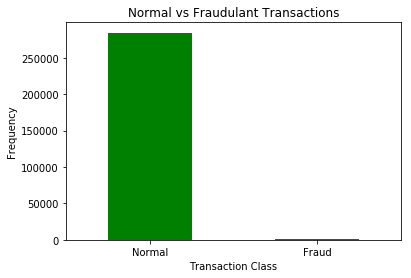

In [7]:
labels = ["Normal", "Fraud"]
count_classes = pd.value_counts(creditcard_df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), labels)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

### Transaction amount per class

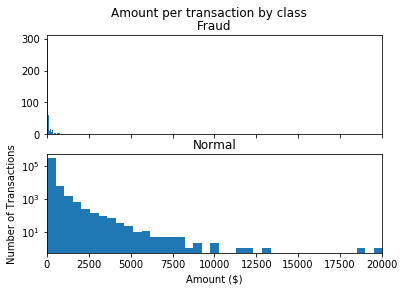

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(creditcard_df[creditcard_df['Class'] ==1].Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(creditcard_df[creditcard_df['Class'] ==0].Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

### Transaction time

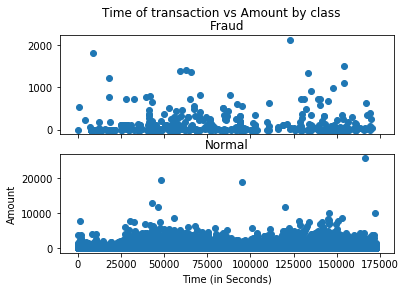

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(creditcard_df[creditcard_df['Class'] ==1].Time, creditcard_df[creditcard_df['Class'] ==1].Amount)
ax1.set_title('Fraud')

ax2.scatter(creditcard_df[creditcard_df['Class'] ==0].Time, creditcard_df[creditcard_df['Class'] ==0].Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [10]:
# create train and test datasets
(train_features, train_labels), (test_features, test_labels) = train_test_split(creditcard_df, train_frac=0.7)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
bucket

'model-bucket-test-1234567'

# Use SageMaker's Linear Learner to Create a model

In [13]:
%%time
from sagemaker import LinearLearner
# instantiate and train a LinearLearner
output_location = f's3://{bucket}/card-fraud-example/output'

# include params for tuning for higher precision
# *and* account for class imbalance in training data
linear = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_location,
                                sagemaker_session=sagemaker_session,
                                epochs=15)

# convert features/labels to numpy
train_x_np = train_features.astype('float32')
train_y_np = train_labels.astype('float32')

# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

# train the estimator on formatted training data
linear.fit(formatted_train_data)

# get the name of the training job
training_job_name = linear.latest_training_job.name

# create a model from the trainig job
print(f'{strftime("%Y-%m-%d-%H-%M-%S", gmtime())} - creating a model from a training job: {training_job_name}')
linear_model_name = sagemaker_session.create_model_from_job(training_job_name=training_job_name, name=f'credit-card-model-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}', role=role)

2019-11-01 16:36:26 Starting - Starting the training job...
2019-11-01 16:36:27 Starting - Launching requested ML instances......
2019-11-01 16:37:31 Starting - Preparing the instances for training.........
2019-11-01 16:39:20 Downloading - Downloading input data
2019-11-01 16:39:20 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[11/01/2019 16:39:42 INFO 140670800815936] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u